In [1]:
# !python recognize2.py

In [6]:
import sys
import os
# sys.path.append(os.path.abspath('../face-recognition/yolov5_face/'))
# sys.path.append(os.path.abspath('../ALPR/Character-Time-series-Matching/yolov5/'))
from yolov5.models.experimental import attempt_load

In [7]:
def load_model(path, train = False):
    # print(self.device)
    model = attempt_load(path, map_location='cpu')  # load FP32 model
    names = model.module.names if hasattr(model, 'module') else model.names  # get class names
    if train:
        model.train()
    else:
        model.eval()
    return model, names

In [8]:
char_model, names = load_model('yolov5_face/char.pt')

yolov5_face/char.pt
<_io.BufferedReader name='yolov5_face/char.pt'>


AttributeError: Can't get attribute 'C3TR' on <module 'models.common' from '/mnt/1A7C64A87C647FFD/Machine Learning/Projects/face-recognition/yolov5_face/models/common.py'>

In [4]:
# yolov5_face/char.pt

In [1]:
#pytorch
from concurrent.futures import thread
from sqlalchemy import null
import torch
from torchvision import transforms
import time
from threading import Thread

#other lib
import sys
import numpy as np
import os
import cv2

In [2]:
print("PyTorch Version: ",torch.__version__)
print("Python Version: ",sys.version)

PyTorch Version:  2.0.0+cu117
Python Version:  3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]


In [6]:
# model = torch.hub.load('ultralytics/yolov5', 'yolov5n')

In [7]:
# sys.path.remove('/mnt/1A7C64A87C647FFD/Machine Learning/Projects/face-recognition/yolov5_face')
# sys.path

In [8]:
# import importlib
# sys.path.insert(0, '/mnt/1A7C64A87C647FFD/Machine Learning/Projects/face-recognition/yolov5_face')
# importlib.reload(sys.modules['utils.general'])

In [5]:
# sys.path.insert(0, "yolov5_face")
sys.path.append(os.path.abspath('../face-recognition/yolov5_face/'))
from yolov5_face.models.experimental import Ensemble, Conv
import torch.nn as nn
from yolov5_face.utils.google_utils import attempt_download
from yolov5_face.utils.datasets import letterbox
from yolov5_face.utils.general import check_img_size, non_max_suppression_face, scale_coords

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def attempt_load2(weights, map_location=None):
    # Loads an ensemble of models weights=[a,b,c] or a single model weights=[a] or weights=a
    model = Ensemble()
    for w in weights if isinstance(weights, list) else [weights]:
        attempt_download(w)
        print(w)
        print(attempt_download(w))
        model.append(torch.load(w, map_location=map_location)['model'].float().fuse().eval())  # load FP32 model

    # Compatibility updates
    for m in model.modules():
        if type(m) in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
            m.inplace = True  # pytorch 1.7.0 compatibility
        elif type(m) is Conv:
            m._non_persistent_buffers_set = set()  # pytorch 1.6.0 compatibility

    if len(model) == 1:
        return model[-1]  # return model
    else:
        print('Ensemble created with %s\n' % weights)
        for k in ['names', 'stride']:
            setattr(model, k, getattr(model[-1], k))
        return model  # return ensemble
    
# Get model detect
## Case 1:
# model = attempt_load("yolov5_face/yolov5m-face.pt", map_location=device)

## Case 2:
model = attempt_load2("yolov5_face/yolov5n-face.pt", map_location=device)

# Get model recognition
## Case 1: 
from insightface.insight_face import iresnet100
weight = torch.load("insightface/resnet100_backbone.pth", map_location = device)
model_emb = iresnet100()

yolov5_face/yolov5n-face.pt
None
<_io.BufferedReader name='yolov5_face/yolov5n-face.pt'>
Fusing layers... 
<_io.BufferedReader name='insightface/resnet100_backbone.pth'>


In [13]:
import torch
torch.load('yolov5_face/yolov5n-face.pt', map_location='cpu')

<_io.BufferedReader name='yolov5_face/yolov5n-face.pt'>


AttributeError: Can't get attribute 'StemBlock' on <module 'models.common' from '/mnt/1A7C64A87C647FFD/Machine Learning/Projects/face-recognition/yolov5/models/common.py'>

In [77]:
model_emb.load_state_dict(weight)
model_emb.to(device)
model_emb.eval()

face_preprocess = transforms.Compose([
                                    transforms.ToTensor(), # input PIL => (3,56,56), /255.0
                                    transforms.Resize((112, 112)),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                    ])

isThread = True
score = 0
name = null

In [83]:
# Resize image
def resize_image(img0, img_size):
    h0, w0 = img0.shape[:2]  # orig hw
    r = img_size / max(h0, w0)  # resize image to img_size

    if r != 1:  # always resize down, only resize up if training with augmentation
        interp = cv2.INTER_AREA if r < 1  else cv2.INTER_LINEAR
        img0 = cv2.resize(img0, (int(w0 * r), int(h0 * r)), interpolation=interp)

    imgsz = check_img_size(img_size, s=model.stride)  # check img_size
    img = letterbox(img0, new_shape=imgsz)[0]

    # Convert
    img = img[:, :, ::-1].transpose(2, 0, 1).copy()  # BGR to RGB, to 3x416x416

    img = torch.from_numpy(img).to(device)
    img = img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    return img

In [11]:

input_image = cv2.imread("car.jpeg")
input_image.shape

(498, 616, 3)

In [82]:
model.stride

32

In [84]:
# Parameters
size_convert = 128
conf_thres = 0.4
iou_thres = 0.5

# Resize image
img = resize_image(input_image.copy(), size_convert)
img.shape

torch.Size([3, 128, 128])

In [91]:
img[None, :].shape

torch.Size([1, 3, 128, 128])

In [85]:
# Via yolov5-face
with torch.no_grad():
    pred = model(img[None, :])[0]

pred

tensor([[3.40685e+00, 4.90495e+00, 1.32465e+01,  ..., 2.29883e-04, 3.45357e-04, 5.30104e-04],
        [1.10403e+01, 5.17460e+00, 2.52162e+01,  ..., 2.36403e-04, 4.18261e-04, 5.81387e-04],
        [1.76687e+01, 5.08252e+00, 2.54493e+01,  ..., 3.29535e-04, 4.73370e-04, 8.04958e-04],
        ...,
        [6.15197e+01, 8.93418e+01, 1.25817e+02,  ..., 6.95433e-04, 5.03694e-04, 4.59124e-04],
        [6.66849e+01, 8.57299e+01, 1.20040e+02,  ..., 5.59329e-04, 5.05853e-04, 4.13727e-04],
        [1.06557e+02, 9.50237e+01, 1.59158e+02,  ..., 1.05225e-03, 6.23474e-04, 6.24733e-04]])

In [86]:
def scale_coords_landmarks(img1_shape, coords, img0_shape, ratio_pad=None):
    # Rescale coords (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2, 4, 6, 8]] -= pad[0]  # x padding
    coords[:, [1, 3, 5, 7, 9]] -= pad[1]  # y padding
    coords[:, :10] /= gain
    #clip_coords(coords, img0_shape)
    coords[:, 0].clamp_(0, img0_shape[1])  # x1
    coords[:, 1].clamp_(0, img0_shape[0])  # y1
    coords[:, 2].clamp_(0, img0_shape[1])  # x2
    coords[:, 3].clamp_(0, img0_shape[0])  # y2
    coords[:, 4].clamp_(0, img0_shape[1])  # x3
    coords[:, 5].clamp_(0, img0_shape[0])  # y3
    coords[:, 6].clamp_(0, img0_shape[1])  # x4
    coords[:, 7].clamp_(0, img0_shape[0])  # y4
    coords[:, 8].clamp_(0, img0_shape[1])  # x5
    coords[:, 9].clamp_(0, img0_shape[0])  # y5
    return coords

In [87]:
# Apply NMS
det = non_max_suppression_face(pred, conf_thres, iou_thres)[0]
bboxs = np.int32(scale_coords(img.shape[1:], det[:, :4], input_image.shape).round().cpu().numpy())

landmarks = np.int32(scale_coords_landmarks(img.shape[1:], det[:, 5:15], input_image.shape).round().cpu().numpy()) 

IndexError: tuple index out of range

In [96]:
results = model(img[None, :])

In [98]:
results.

AttributeError: 'Tensor' object has no attribute 'pred'

In [99]:
import cv2
import torch
from PIL import Image


# Images
for f in 'zidane.jpg', 'bus.jpg':
    torch.hub.download_url_to_file('https://ultralytics.com/images/' + f, f)  # download 2 images
im1 = Image.open('zidane.jpg')  # PIL image
im2 = cv2.imread('bus.jpg')[..., ::-1]  # OpenCV image (BGR to RGB)

# Inference
results = model([im1, im2], size=640) # batch of images

# Results
results.print()  
results.save()  # or .show()

results.xyxy[0]  # im1 predictions (tensor)
results.pandas().xyxy[0]  # im1 predictions (pandas)
#      xmin    ymin    xmax   ymax  confidence  class    name
# 0  749.50   43.50  1148.0  704.5    0.874023      0  person
# 1  433.50  433.50   517.5  714.5    0.687988     27     tie
# 2  114.75  195.75  1095.0  708.0    0.624512      0  person
# 3  986.00  304.00  1028.0  420.0    0.286865     27     tie

100%|██████████| 165k/165k [00:00<00:00, 3.13MB/s]
100%|██████████| 476k/476k [00:00<00:00, 1.98MB/s]
image 1/2: 720x1280 2 persons, 1 tie
image 2/2: 1080x810 3 persons, 1 bus
Speed: 64.6ms pre-process, 198.8ms inference, 168.2ms NMS per image at shape (2, 3, 640, 640)
Saved 2 images to runs/detect/exp


,xmin,ymin,xmax,ymax,confidence,class,name
0,742.367920,39.880829,1154.103638,716.050781,0.789693,0,person
1,135.696411,180.749695,739.330811,720.000000,0.368303,0,person
2,438.216583,434.265869,503.571320,711.379761,0.271155,27,tie


In [12]:
# Inference
results2 = model(input_image) 

results2.pandas().xyxy[0]
results2.show()

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [123]:
lic_model = torch.hub.load('ultralytics/yolov5', 'custom', path='object.pt')

Using cache found in /home/ali/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-10-27 Python-3.10.13 torch-2.0.0+cu117 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7039792 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


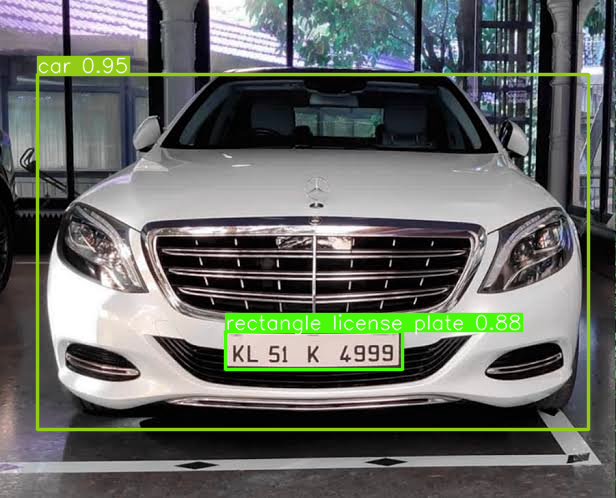

In [138]:
input_image = cv2.imread("car.jpeg")
results3 = lic_model(input_image) 

results3.pandas().xyxy[0]
results3.show()

In [131]:
%matplotlib inline

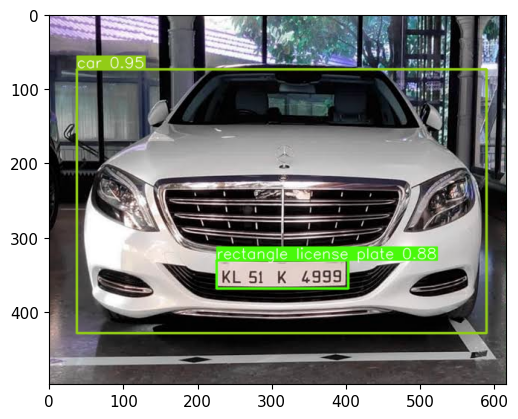

In [139]:
plt.imshow(input_image)
plt.show()

Using cache found in /home/ali/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-10-27 Python-3.10.13 torch-2.0.0+cu117 CPU

Fusing layers... 
YOLOv5_transformer summary: 181 layers, 1214114 parameters, 0 gradients
Adding AutoShape... 


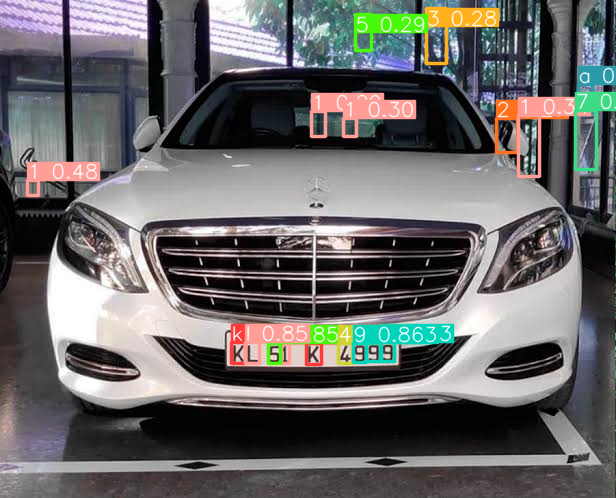

In [133]:
char_model = torch.hub.load('ultralytics/yolov5', 'custom', path='char.pt')

In [13]:
input_image = cv2.imread("car.jpeg")
results3 = char_model(input_image) 

results3.pandas().xyxy[0]
results3.show()

NameError: name 'char_model' is not defined

In [6]:
!python recognize2.py

Fusing layers... 
/home/ali/anaconda3/envs/facerec/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Using cache found in /home/ali/.cache/torch/hub/ultralytics_yolov5_master
Traceback (most recent call last):
  File "/mnt/1A7C64A87C647FFD/Machine Learning/Projects/face-recognition-20230919T215152Z-001/face-recognition/recognize2.py", line 412, in <module>
    main()
  File "/mnt/1A7C64A87C647FFD/Machine Learning/Projects/face-recognition-20230919T215152Z-001/face-recognition/recognize2.py", line 318, in main
    char_model = torch.hub.load('ultralytics/yolov5', 'custom', path='char.pt')
  File "/home/ali/anaconda3/envs/facerec/lib/python3.10/site-packages/torch/hub.py", line 558, in load
    model = _load_local(repo_or_dir, model, *args, 